# Simulation

In [1]:
import pickle
import numpy as np
import pandas as pd
from numpy.random import default_rng
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
import gensim
import os
from IPython.display import clear_output
from functions import one_hot
from ETM_raw.scripts.data_preprocessing import *
from Simulations import Simulation_BBC
from IPython.display import clear_output
rng = default_rng(seed = 2)

In [4]:
import os
os.getcwd()
from model import deeplptm

In [ ]:
import os
#from Simulations_BBC import Simulation_BBC
from ETM_raw.scripts.data_preprocessing import preprocessing
np.set_printoptions(precision=2)

# To begin with
SIMULATIONS_root = 'Simulations/'
BBC_root         = os.path.join(SIMULATIONS_root, 'bbc')

scenario             = 'ScenarioC'
simulate_new_dataset = False

if simulate_new_dataset:
    # Not working properly. Different results than with R dataset with the same parameters. To investigate.
    simu_path        = os.path.join(BBC_root, scenario)
    Q, K, A, T, W, pi, node_cluster, topics =Simulation_BBC(BBC_root, 
                                                            save_path=simu_path,
                                                            N=100,
                                                            scenario='ScenarioB',
                                                            difficulty = 'Easy',
                                                            verbose=True)
    topics = T[A != 0]
else:
    simu_path        = os.path.join(BBC_root, scenario, '1/')
    A                = pd.read_csv(os.path.join(simu_path, 'adjacency.csv'),
                           index_col=None, header=None, sep=';').to_numpy()
    node_cluster     = pd.read_csv(os.path.join(simu_path, 'clusters.csv'),
                           index_col=None, header=None,sep=';').to_numpy().squeeze() - 1
    W                = pd.read_csv(os.path.join(simu_path, 'texts.csv'),
                           index_col=None, header=None, sep='/').to_numpy()
    T                = pd.read_csv(os.path.join(simu_path, 'topics.csv'),
                           index_col=None, header=None, sep=';').to_numpy()
    
    topics   = T[A != 0] - 1
    K        = np.unique(topics).shape[0]
    Q        = np.unique(node_cluster).shape[0]
    W        = W[A != 0].tolist()
    #args.hidden2_dim = 3
    N = A.shape[0]
    M = A.sum()
    
# Preprocess the texts using ETM preprocessing tools
etm_path = os.path.join(simu_path, 'etm/')
  

# Representation of the data

C:\Users\remib\Anaconda3\envs\GCN\lib\site-packages\netgraph\_node_layout.py:993: RuntimeWarning: invalid value encountered in divide
  directions = deltas / magnitudes[:, np.newaxis]


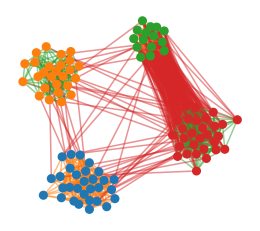

In [3]:
import networkx as nx
from netgraph import Graph
import matplotlib.pyplot as plt
G = nx.DiGraph()
edges = np.where(A)
for (i, j) in zip(edges[0].tolist(), edges[1].tolist()):
    G.add_edge(i, j)
    
    
community_to_color = {
    0 : 'tab:blue',
    1 : 'tab:orange',
    2 : 'tab:green',
    3 : 'tab:red',
}

node_to_cluster = {node: node_cluster[node] for node in G.nodes}
edge_to_topic   = {(i,j):T[i,j] for (i,j) in zip(edges[0], edges[1])}

node_color = {node: community_to_color[cluster] for node, cluster in node_to_cluster.items()}
edge_color = {edge: community_to_color[topic] for edge, topic in edge_to_topic.items()}

Graph(G,
      node_color=node_color, node_edge_width=0, edge_alpha=0.5, edge_color = edge_color,
      node_layout='community', node_layout_kwargs=dict(node_to_community=node_to_cluster))
plt.show()


In [4]:
preprocessing(W, path_save=etm_path, max_df=1., min_df=1, prop_Tr=1, vaSize = 0)

reading data...
counting document frequency of words...
building the vocabulary...
  initial vocabulary size: 799
  vocabulary size after removing stopwords from list: 595
tokenizing documents and splitting into train/test/valid...
  vocabulary after removing words not in train: 595
  number of documents (train): 863 [this should be equal to 863]
  number of documents (test): 0 [this should be equal to 0]
  number of documents (valid): 0 [this should be equal to 0]
removing empty documents...
splitting test documents in 2 halves...
creating lists of words...
  len(words_tr):  60922
  len(words_ts):  0
  len(words_ts_h1):  0
  len(words_ts_h2):  0
  len(words_va):  0
getting doc indices...
  len(np.unique(doc_indices_tr)): 863 [this should be 863]
  len(np.unique(doc_indices_ts)): 0 [this should be 0]
  len(np.unique(doc_indices_ts_h1)): 0 [this should be 0]
  len(np.unique(doc_indices_ts_h2)): 0 [this should be 0]
  len(np.unique(doc_indices_va)): 0 [this should be 0]
creating bow repr

C:\Users\remib\Anaconda3\envs\GCN\lib\site-packages\scipy\io\matlab\_mio5.py:493: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  narr = np.asanyarray(source)


In [5]:
assert int(A.sum()) == len(W), 'The number of texts and edges is different. A simulation problem occured'

# Initialise ETM and Deep-LPM
If the models are not initialised, it might be more difficult to recover the true partition. In addition, the running time would be much more important to obtain interesting node positions. 

## ETM initialisation

In [8]:
from ETM_raw.main import ETM_algo
import torch
from ETM_raw.data import get_batch
from sklearn.metrics import adjusted_rand_score as ARI

use_pretrained_emb = False
etm_init_epochs    = 5
seed               = 0 

etm = ETM_algo(data_path= etm_path,
               dataset='BBC',
               seed=seed,
               enc_drop=0,
               train_embeddings=True,
               use_pretrained_emb=use_pretrained_emb,
               emb_path=None,
               save_path=etm_path,
               batch_size=30,
               epochs=etm_init_epochs,
               num_topics=K)

etm.model.float()
etm.train_etm()
DTM = get_batch(etm.train_tokens, etm.train_counts, range(etm.train_tokens.shape[0]), len(etm.vocab), device='cuda')
DTM_norm = DTM / DTM.sum(1,keepdims=True)

theta, _ = etm.model.get_theta(DTM_norm)
theta    = theta.detach().cpu().numpy()
clear_output()

print('Documents ARI : {}'.format(ARI(topics, theta.argmax(-1))))        
torch.save(etm, os.path.join(etm_path, 'etm_init_pretrained_{}.pt'.format(int(use_pretrained_emb))))

Documents ARI : 1.0


## Deep-LPM initialisation

In [9]:
from os.path import join
from functions import DeepLPM_format
from deepLPM_main import model as Model
from deepLPM_main import args
from functions import training_graph_vectorization
from torch.optim import Adam

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

M = int(A.sum())
P = 2
N = int(A.shape[0])

"""
adj = np.load(join(simu_path, 'adjacency.npy'))
clusters = np.load(join(simu_path, 'clusters.npy'))

args.P = 2
args.K = K
args.num_clusters = Q
args.device = device
args.num_points= A.shape[0]
args.num_edges = int(A.sum())
"""


#args.K = K
args.P = 2
args.hidden2_dim = P
#args.M = M
#args.N = N
#args.Q = Q
args.num_clusters = Q
args.num_points   = N
args.K            = K
args.num_edges    = M
args.device       = device
adj, adj_label, adj_norm, features, edges, indices = DeepLPM_format(A, args)
args.indices = indices

deepLPM = getattr(Model, args.model)(adj_norm)
deepLPM.to(device)  # to GPU
deepLPM.pretrain(features, adj_label, edges, verbose=False)  # pretraining
optimizer = Adam(deepLPM.parameters(), lr=args.learning_rate)  # , weight_decay=0.01
deepLPM = deepLPM.to(device)

print('DeepLPM ARI : {}'.format(ARI(deepLPM.gamma.argmax(-1).detach().cpu().numpy(),
                                    node_cluster)))

Finish pretraining!
DeepLPM ARI : 0.4446642361863007


C:\Users\remib\Anaconda3\envs\GCN\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [10]:
args.K            = K
args.num_edges    = M

# Deep-LPTM training

In [13]:
results = training_graph_vectorization(adj_label,
                                       features,
                                       edges,
                                       optimizer,
                                       etm,
                                       deepLPM,
                                       args,
                                       labels=node_cluster,
                                       topics=T[A!=0],
                                       epochs=50,
                                       tol=1e-3,
                                       adj=A,
                                       ratio=False,
                                       use='all',
                                       init='dissimilarity', 
                                       init_path=None,
                                       full_batch = False,
                                       device=None)

ARI of initialisation : 0.98
Epoch----->0 .. LR: 0.005 .. KL_theta: 6.02 .. Rec_loss: 354.44 .. NELBO: 360.46
ARI texts= 1.000
ARI= 1.000
Epoch: 0001 network_loss = 3264.00195 train_loss1= 3017.21191 train_loss2= 111.65942 train_loss3= 135.13063 KL texts = 0.119 recon loss texts = 354.111 time= 1.00 sec
Epoch----->0 .. LR: 0.005 .. KL_theta: 0.82 .. Rec_loss: 352.68 .. NELBO: 353.5
ARI texts= 1.000
ARI= 1.000
Epoch: 0002 network_loss = 3065.65649 train_loss1= 2818.95654 train_loss2= 111.72216 train_loss3= 134.97786 KL texts = 0.061 recon loss texts = 351.887 time= 0.86 sec
Epoch----->0 .. LR: 0.005 .. KL_theta: 0.35 .. Rec_loss: 351.92 .. NELBO: 352.27
ARI texts= 1.000
ARI= 1.000
Epoch: 0003 network_loss = 3239.00830 train_loss1= 2991.66821 train_loss2= 112.39246 train_loss3= 134.94756 KL texts = 0.039 recon loss texts = 351.200 time= 0.87 sec
Epoch----->0 .. LR: 0.005 .. KL_theta: 0.13 .. Rec_loss: 351.5 .. NELBO: 351.63
ARI texts= 1.000
ARI= 1.000
Epoch: 0004 network_loss = 3236.4003

# Results
First, we ensure that the ELBO increased during the training.

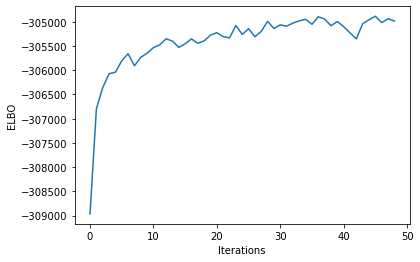

In [21]:
import matplotlib.pyplot as plt

plt.plot(results['elbo'])
plt.ylabel('ELBO')
plt.xlabel('Iterations')
plt.show()

Second, we plot the representation of the network with the information gathered by DeepLPTM, regarding the nodes and the edges.

In [29]:
clusters_dlptm = {node: results['tau'].argmax(-1)[node] for node in G.nodes}
node_positions = { node: (results['mu_X'][node, 0], results['mu_X'][node, 1]) for node in G.nodes}
node_colors    = { node: community_to_color[clusters_dlptm[node]] for node in G.nodes}

T_dlptm        = np.copy(T)
T_dlptm[A != 0]= results['theta'].argmax(-1)
topics_dlptm   = {(i,j): T_dlptm[i, j] for (i,j) in G.edges}
edge_colors   = { (i,j): community_to_color[topics_dlptm[(i,j)]] for (i,j) in G.edges}

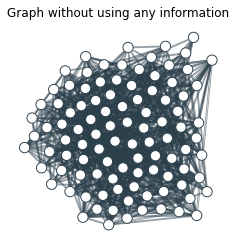

In [40]:
Graph(G)
plt.title('Graph without using any information')
plt.show()

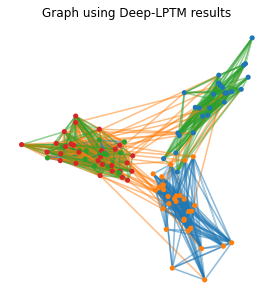

In [41]:
node_color = {node: community_to_color[cluster] for node, cluster in node_to_cluster.items()}

plt.figure(figsize=(5,5))
Graph(G, 
      node_layout=node_positions,
      node_color= node_colors, 
      edge_color = edge_colors,
      node_size = 5,
      node_edge_width=0,
      edge_alpha=0.5,
      edge_width=3)
plt.title('Graph using Deep-LPTM results')
plt.show()